# <center> Importazione delle librerie ed impostazioni di sistema

In [1]:
import pandas as pd
import numpy as np
import warnings
import itertools
import math
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from pylab import rcParams
import statsmodels.api as sm
from statsmodels.tsa import api as smt
from statsmodels.tsa.api import ExponentialSmoothing, SimpleExpSmoothing, Holt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima_model import ARMA,ARMAResults,ARIMA,ARIMAResults
from statsmodels.tsa.statespace.sarimax import SARIMAX
import datetime
from datetime import datetime, timedelta
import tensorflow as tf
from tensorflow.keras.models import load_model
from pmdarima import auto_arima  ## choosing ARIMA orders
from statsmodels.graphics.tsaplots import plot_acf,plot_pacf 
from statsmodels.tools.eval_measures import mse,rmse, meanabs  ## model evaluation
from statsmodels.graphics.tsaplots import month_plot, quarter_plot, seasonal_plot
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.ensemble import RandomForestRegressor

# Recurrent Neural Networks
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.callbacks import EarlyStopping

# Facebook Prophet
from fbprophet import Prophet
from fbprophet.diagnostics import cross_validation,performance_metrics
from fbprophet.plot import plot_cross_validation_metric
from fbprophet.plot import add_changepoints_to_plot

# Ignore the warning
warnings.filterwarnings("ignore")

# For graphing purpose 
plt.style.use('seaborn-bright')
matplotlib.rcParams['axes.labelsize'] = 14
matplotlib.rcParams['xtick.labelsize'] = 12
matplotlib.rcParams['ytick.labelsize'] = 12
matplotlib.rcParams['text.color'] = 'k'

# <center> Funzioni

# Funzioni generali

In [2]:
def nice_plotting(title ='', xlabel='', ylabel='', new_fig= False , figsize= (10,6), title_size=18):
    
    """Questa funzione permette di personalizzare facilmente i grafici prodotti con pyplot"""
    
    if new_fig== True:
        plt.figure(figsize=figsize)
        
    plt.title(title, color= 'xkcd:pale red', fontsize= title_size, pad= 13, fontweight= 'bold')
    plt.xlabel(xlabel, color='xkcd:pale red', fontsize= 14, fontweight= 'bold')
    plt.ylabel(ylabel, color= 'xkcd:pale red', fontsize= 14, fontweight= 'bold')
    plt.xticks(fontsize=12, color= 'xkcd:cadet blue')
    plt.yticks(fontsize=12, color= 'xkcd:cadet blue')
   

# Importazione dei dati e prima esplorazione

In [3]:
def import_data(path, date_col_name):
    
    """Questa funzione importa i data ed indicizza la colonna corrispondente alla data, 
    convertita in un oggetto DateTime"""
    
    df = pd.read_csv(path, parse_dates=[date_col_name])
    df.set_index('date', inplace=True)
    return df


In [4]:
def describe_by_decile(df):
    
    """Questa funzione calcola una serie di statistiche descrittive delle variabili del 
    dataset"""
    
    summary = round(df.describe(percentiles = np.arange(0.1,1,0.1)), 1)
    summary = pd.DataFrame(summary)
    return summary


# Data Visualization e Analisi di Stazionarita'

In [5]:
def ts_visualisation(df,target_col_name):
    
    """Questa funzione restituisce una time line aggregata per diversi livelli della serie 
    storica da predire ed un plot standard per ciascuna delle altre serie storiche eventualmente
    presenti nel dataset"""
    
    freq = pd.infer_freq(df.index)
    fig, ax = plt.subplots(figsize=(20, 6))
    
    if freq is None:
        ax.plot(df[target_col_name], marker='.', linestyle='-', linewidth=0.5)
    
    elif "D" in freq:
        ax.plot(df[target_col_name], marker='.', linestyle='-', linewidth=0.5, label='Daily')
        ax.plot(df[target_col_name].resample('W').mean(),marker='o', markersize=8, linestyle='-', 
                label='Weekly Mean Resample')
        ax.plot(df[target_col_name].resample('M').mean(),marker='x', markersize=8, linestyle='-', 
                label='Monthly Mean Resample')
        ax.legend();
    elif "W" in freq:
        print(freq)
        ax.plot(df[target_col_name], marker='.', linestyle='-', linewidth=0.5, label='Weekly')
        ax.plot(df[target_col_name].resample('M').mean(), marker='o', markersize=8, 
                linestyle='-', label='Monthly Mean Resample')
        ax.legend();
    elif "M" in freq:
        print(freq)
        ax.plot(df[target_col_name], marker='.', linestyle='-', linewidth=0.5, label='Monthly')
    
    else:
        ax.plot(df[target_col_name], marker='.', linestyle='-', linewidth=0.5)

    plt.show()
    
    # Plot each column
    
    if df.shape[1] > 1:
        
        values = df.values
        columns = np.arange(0,df.shape[1],1)
        i = 1
        nice_plotting(new_fig=True)
        for col in columns:
            plt.subplot(len(columns), 1, i)
            plt.plot(values[:, col])
            plt.title(df.columns[col], y=0.5, loc='right')
            i += 1
        plt.show()
    

In [6]:
def ts_decomposition(df, target_col_name, model = 'additive'):
    
    """Questa funzione scompone la serie storica in trend, stagionalitá ed errore, 
    eventualmente previo un resampling della stessa"""
        
    series = df[target_col_name]
    
    decomposition = sm.tsa.seasonal_decompose(series, 
                                              model=model,extrapolate_trend='freq')
    fig = decomposition.plot()
    fig.set_size_inches(14,7)
    plt.show()


In [7]:
def acf_pacf_plotting(df, target_col_name):
    
    """Questa funzione restituisce due risultati grafici: l'Autocorrelation plot ed il Partial Autocorrelation
    plot per la serie originaria o per la serie differenziata, in base all'ordine passato come argomento"""

    fig, axes = plt.subplots(2, figsize=(12,7))
    fig = sm.graphics.tsa.plot_acf(df[target_col_name], lags=40, ax=axes[0])
    fig = sm.graphics.tsa.plot_pacf(df[target_col_name], lags=40, ax=axes[1])


In [8]:
def adf_test(df, target_col_name, alpha= 0.05):
    
    """Questa funzione esegue un ADF test sulla serie originaria e stampa un report strutturato relativo 
    al risultato del test. Se la serie non é stazionaria, restituisce in output il numero di differenze 
    necessarie per rendere la serie stazionaria e stampa due risultati grafici corrispondenti alla serie
    storica originaria e al corrispettivo stazionario ottenuto mediante differenziazione"""
    
    result = adfuller(df[target_col_name],autolag='AIC')
    print(f'ADF Statistic: {result[0]}')
    print(f'p-value: {result[1]}')
    print(f'n_lags: {result[2]}')
    print('Critial Values:')
    for key, value in result[4].items():
        print(f'   {key}, {value}')    
    if result[1] <= alpha:
        print("Reject the null hypothesis")
        print("Data has no unit root and is stationary")
        
    else:
        print("Do not reject the null hypothesis")
        print("Data has a unit root and is non-stationary")
        for i in range(1,10):
            
            target_col_diff = df[target_col_name].diff(i).dropna()
            result_adf_diff = adfuller(target_col_diff,autolag='AIC')
            diff = i
            if result_adf_diff[1] <= alpha:
                print(f"Differencing the serie {diff} time(s), makes the data stationary")
                # Graph data
                fig, axes = plt.subplots(1, 2, figsize=(15,4))

                # Levels
                axes[0].plot(df.index._mpl_repr(), df[target_col_name], '-')
                axes[0].set(title='Original TS')

                # Difference
                axes[1].plot(df.index._mpl_repr(), df[target_col_name].diff(diff), '-')
                axes[1].hlines(0, df.index[0], df.index[-1], 'r')
                axes[1].set(title=f'Differenced TS (order={diff})');
                plt.show()
                break
            else:
                print("Data cannot be made stationary through differencing")


In [9]:
def ts_sintetic_plot(df, target_col_name, lags=None, figsize=(12, 7), window = 12):
    
    """Questa funzione restituisce il risultato di un ADF test, il plot di una serie temporale 
    interpolata da una media mobile con finestra temporale specificata in input, ACF e PACF"""
    
    serie = df[target_col_name]
    
    fig = plt.figure(figsize=(12, 7))
    layout = (2, 2)
    acf_ax = plt.subplot2grid(layout, (1, 0))
    pacf_ax = plt.subplot2grid(layout, (1, 1))
    mean_std_ax = plt.subplot2grid(layout, (0, 0), colspan=2)

    rolmean = serie.rolling(window=window).mean()
    rolstd = serie.rolling(window=window).std()

    # Plot rolling statistics:
    orig = plt.plot(serie, color= 'blue', label='Original')
    mean = plt.plot(rolmean, color='red', label='Rolling Mean')
    plt.legend(loc='best')
    serie.plot(ax=mean_std_ax, xlabel="")
    p_value = sm.tsa.stattools.adfuller(serie)[1]
    h0_result = "We reject stationarity" if p_value > 0.05 else "We do not reject stationarity"
    mean_std_ax.set_title(f"""Time Series stationarity analysis Plots\n
    Dickey-Fuller: p={p_value} Result: {h0_result}""")
    smt.graphics.plot_acf(serie, lags=lags, ax=acf_ax)
    smt.graphics.plot_pacf(serie, lags=lags, ax=pacf_ax)
    plt.tight_layout()
    

# Split in Train e Test Set

In [10]:
def split_train_test(df, test_size=0.25):
    
    """Questa funzione restituisce rispettivamente i dataset train e test, costruiti a partire dal dataset 
    originario eseguendo lo split in base alla dimensione del test passata come parametro alla funzione"""
    
    n_out_of_sample_obs = math.floor(df.shape[0]*test_size)

    # Set one month for testing
    train = df.iloc[:-n_out_of_sample_obs]
    test = df.iloc[-n_out_of_sample_obs:]
    
    print(f"{len(train)} periods of training data \n {len(test)} periods of testing data ")
    return train, test


# Modelli

## Naive models

In [11]:
def naive_model_mean(train, test, target_col_name):
    mean = train[target_col_name].mean()
    predictions_test = np.array([mean for u in range(len(test))])
    return predictions_test

## AR, MA, ARMA, ARIMA, SARIMA e SARIMAX

### Tuning

In [12]:
def tune_arima_model(train, target_col_name):
        
    """Questa funzione restituisce l'ordine di un modello ARIMA(p, d, q) che, fra varie combinazioni generate
    mediate una procedura di tipo stepwise, minimizza il BIC."""
        
    arima_tuning = auto_arima(
        train[target_col_name],
        start_p=0,
        start_q=0,
        max_p=6,
        max_q=3,
        trace=True,
        stepwise=True,
        information_criterion='bic',
        maxiter=1000,
        random_state=42)

    arima_order = arima_tuning.order

    return arima_order
    

In [13]:
def tune_sarima_model(df, target_col_name, seasonality = 7):
        
    """Questa funzione restituisce ordine ed ordine stagionale di un modello SARIMA(p, d, q)(P, D, Q, s) che, 
    fra varie combinazioni generate mediante una procedura di tipo stepwise, minimizza il BIC."""
        
    sarima_tuning = auto_arima(
        train[target_col_name],
        start_p=0,
        start_q=0,
        max_p=6,
        max_q=3,
        seasonal=True,
        m=seasonality,  
        trace=True,
        stepwise=True, 
        information_criterion='bic',
        maxiter=1000,
        random_state=42)

    sarima_order = sarima_tuning.order
    sarima_seasonal_order = sarima_tuning.seasonal_order

    return sarima_order, sarima_seasonal_order
    

In [14]:
def tune_sarimax_model(train, target_col_name, seasonality = 7):
    
    """Questa funzione restituisce, tra varie combinazioni di parametri considerate con procedura stepwise, 
    ordine e ordine stagionale di un modello SARIMAX minimizzanti il BIC. Per replicare un out-of-sample 
    scenario é possibile non considerare un numero dato di osservazioni, da destinare alla validazione/test 
    del modello"""
    
    endog = train[target_col_name]
    exog = train.drop([target_col_name],axis=1)
    
    if exog.shape[1]==0:
        
        print("No exogenous variables available to use as regressors: the result will be a SARIMA model\n")
    
        sarima_tuning = auto_arima(
            endog,
            start_p=0,
            start_q=0,
            max_p=6,
            max_q=3,
            seasonal=True,
            m=seasonality,  
            trace=True,
            stepwise=True, 
            information_criterion='bic',
            maxiter=1000,
            random_state=42)

        sarima_order = sarima_tuning.order
        sarima_seasonal_order = sarima_tuning.seasonal_order
        
        return sarima_order, sarima_seasonal_order

    else:
    
        sarimax_tuning = auto_arima(
            endog,
            exog = exog,
            start_p=0,
            start_q=0,
            max_p=6,
            max_q=3,
            seasonal=True,
            m=seasonality,  
            trace=True,
            stepwise=True, 
            information_criterion='bic',
            maxiter=1000,
            random_state=42)

        sarimax_order = sarimax_tuning.order
        sarimax_seasonal_order = sarimax_tuning.seasonal_order

        return sarimax_order, sarimax_seasonal_order
    

### Fitting

In [15]:
def fit_sarimax_model(train, test, target_col_name, order, seasonal_order=None, exog="yes"): 
    
    """Questa funzione esegue il fitting (calcolo dei parametri) del modello SARIMAX, il cui ordine viene 
    inserito in input. L'utente puó decidere quante osservazioni del dataset destinare all'out-of-sample 
    forecasting. La funzione restituisce in output due oggetti di tipo SARIMAXResultsWrapper, relativi, 
    rispettivamente, ai risultati in-sample ed al solo test set"""
    
    valid = {'yes', 'no'}
    if exog not in valid:
        raise ValueError(f"'exog' parameter can take either of {str(valid)}")
        
    exog_train = train.drop([target_col_name],axis=1)
    
    if exog_train.shape[1]==0 or exog == 'no':
                
        print("Result is be a SARIMA model\n")
       
        sarima_modelA = SARIMAX(train[target_col_name], 
            order= order, seasonal_order = seasonal_order)

        train_fit= sarima_modelA.fit()

        print(train_fit.summary())
        print('\nSpecification of the model\n')
        print(pd.Series(train_fit.specification))
        
        sarima_modelB = sm.tsa.SARIMAX(test[target_col_name], 
            order= order, seasonal_order = seasonal_order) 
        
        test_results = sarima_modelB.filter(train_fit.params) # 'filter' fits modelA's params 
                                                              # on the dataset of modelB
        test_results.plot_diagnostics(figsize=(16, 8))
        plt.show()
        
        return train_fit, test_results
    
    else:
        
        sarimax_modelA = SARIMAX(train[target_col_name], 
            exog = exog_train.values,
            order= order, seasonal_order = seasonal_order)

        train_fit= sarimax_modelA.fit()

        print(train_fit.summary())
        print('\nSpecification of the model\n')
        print(pd.Series(train_fit.specification))
        
        exog_test = test.drop([target_col_name],axis=1)
        
        sarimax_modelB = sm.tsa.SARIMAX(test[target_col_name], 
            exog = exog_test.values,
            order= order, seasonal_order = seasonal_order)
        
        test_results = sarimax_modelB.filter(train_fit.params) 
        
        test_results.plot_diagnostics(figsize=(16, 8))
        plt.show()

        return train_fit, test_results


### Predizioni

In [16]:
def predict_with_sarima(df, target_col_name, fitted_sarima, train, test):
    
    order = fitted_sarima.specification['order']
    seasonal_order = fitted_sarima.specification['seasonal_order']
    
    start=len(train)
    end = len(train)+len(test)-1
    
    train_pred_sarima = fitted_sarima.predict(start= 1, end= len(train), typ= 'levels')
    test_pred_sarima = fitted_sarima.predict(start=start, 
                                           end=end, 
                                           typ='levels').rename("Predictions")
    nice_plotting(new_fig=True, title = f'SARIMA{order}{seasonal_order} Forecast')
    plt.plot(df[target_col_name], label='Actual')
    plt.plot(train_pred_sarima, color='green', label='Predictions on Train')
    plt.plot(test_pred_sarima, color='orange', label='Predictions on Test')
    plt.legend();
    
    return train_pred_sarima, test_pred_sarima

In [17]:
def predict_with_sarimax(df, target_col_name, fitted_sarimax, train, test):
    order = fitted_sarimax.specification['order']
    seasonal_order = fitted_sarimax.specification['seasonal_order']
    
    start=len(train)
    end = len(train)+len(test)-1
    
    exog_forecast_test = test.drop([target_col_name],axis=1)
    test_pred_sarimax = fitted_sarimax.predict(start=start, 
                                           end=end, exog = exog_forecast_test,
                                           typ='levels').rename("Predictions")
    
    nice_plotting(new_fig=True, title = f'SARIMAX{order}{seasonal_order} Forecast')
    plt.plot(df[target_col_name], label='Actual')
    plt.plot(test_pred_sarimax, color='orange', label='Predictions on Test')
    plt.legend();
    return test_pred_sarimax

## Machine Learning

### Scaling

In [18]:
def scale_data(train, test):
    
    """Questa funzione prepara i dati per i modelli di ML che utilizzano il Gradient Descent 
    come criterio di ottimizzazione"""
    
    scaler = RobustScaler()
    train_scaled_array = scaler.fit(train)  # No cheating! Don't scale on test!
    train_scaled_array = scaler.transform(train)
    test_scaled_array = scaler.transform(test)

    train_scaled = pd.DataFrame(train_scaled_array, columns=train.columns)
    test_scaled = pd.DataFrame(test_scaled_array, columns=test.columns)
    
    return train_scaled, test_scaled, scaler

### LSTM Model Fitting

In [19]:
def fit_lstm_model(train, test, target_col_name, n_inputs = 7, batch_size = 16, 
                   patience = 20, epochs = 30, units = 100, act_f = 'relu'):
    
    ## Scale variables
    
    train_scaled, test_scaled, scaler = scale_data(train, test)

    ## Create TimeseriesGenerator objects for train and validation

    generator = TimeseriesGenerator(train_scaled, train_scaled[target_col_name], length=n_inputs, 
                                    batch_size=batch_size)
    val_generator = TimeseriesGenerator(test_scaled, test_scaled[target_col_name], length=n_inputs, 
                                        batch_size=batch_size)
    
    early_stop = EarlyStopping(monitor='val_loss', patience=patience)
    
    n_features = train_scaled.shape[1]

    # initialize model
    LSTM_model = Sequential()
    
    # Simple RNN layer
    LSTM_model.add(LSTM(units, activation=act_f, input_shape=(n_inputs, n_features)))
    
    # Final Predictions (one neuron per feature)
    LSTM_model.add(Dense(train_scaled.shape[1])) 
    LSTM_model.compile(optimizer='adam', loss='mse')
    
    # fit model
    LSTM_model.fit_generator(generator, epochs=epochs, validation_data = val_generator, 
                             callbacks=[early_stop])
    
    print(LSTM_model.summary())
    
    # plot loss function on validation
    losses = pd.DataFrame(LSTM_model.history.history)
    losses.plot()
    
    # Saving model
    LSTM_model.save('lstm_model.h5')

    # Loading model
    trained_model = load_model('lstm_model.h5')
    
    return trained_model

### LSTM Predizioni

In [20]:
def predict_with_lstm(df, train, test, target_col_name, trained_model, n_inputs = 7):
    
    ## Scale variables
    
    scaler = RobustScaler()
    scaled_train = scaler.fit_transform(train)
    scaled_test = scaler.transform(test)
    
    n_features = scaled_train.shape[1]
    test_predictions = []

    first_eval_batch = scaled_train[-n_inputs:]
    current_batch = first_eval_batch.reshape((1, n_inputs, n_features))

    for i in range(len(test)):

        # get prediction 1 time stamp ahead ([0] is for grabbing just the number instead of [array])
        current_pred = trained_model.predict(current_batch)[0]

        # store prediction
        test_predictions.append(current_pred) 

        # update batch to now include prediction and drop first value
        current_batch = np.append(current_batch[:,1:,:],[[current_pred]],axis=1)
    
    pred_col_name = []
    for col in test:
        pred_col_name.append("pred_"+col)

    true_predictions = scaler.inverse_transform(test_predictions)
    true_predictions = pd.DataFrame(data=true_predictions,columns=pred_col_name, index= test.index)

    test_pred= test.join(true_predictions)


    nice_plotting(new_fig=True, title = f'LSTM Forecast')
    plt.plot(df[target_col_name], label='Actual')
    plt.plot(test_pred['pred_'+target_col_name], color='orange', label='Predictions on Test')
    plt.legend();

    return test_pred['pred_'+target_col_name]

## Performance Assessment

In [21]:
def evaluate(test, target_col_name, test_pred):
    
    error1x = mse(test[target_col_name], test_pred)
    error2x = rmse(test[target_col_name], test_pred)
    adj_mape= error2x*100/test[target_col_name].mean()

    print('**Evaluation on test**\n')
    print(f'MSE Error: {error1x:11.10}')
    print(f'RMSE Error: {error2x:11.10}')
    print(f'Adjusted MAPE Error: {adj_mape:11.10}%')

# <center> Applicazione

# Import data and have a peek

In [22]:
data_path = 'C:/Users/saram/Documents/UniTorVergata/Tesi/Data/'
file_name = 'sales_exog_w.csv'
target_col = 'sales'
date_col = 'date'

In [23]:
df = import_data(data_path+file_name, date_col)
df.head()

,sales,oil_price,num_holidays
date,,,
2013-01-07,5072.239000,93.1075,1
2013-01-14,5661.835196,93.5940,0
2013-01-21,5606.194005,94.6600,0
2013-01-28,5394.873000,95.5200,0
2013-02-04,5373.959000,97.3840,0


In [24]:
describe_by_decile(df)

,sales,oil_price,num_holidays
count,242.0,242.0,242.0
mean,9176.6,67.8,0.2
std,2652.7,25.7,0.4
min,4515.8,27.8,0.0
10%,5549.3,41.5,0.0
20%,5975.5,45.5,0.0
30%,6657.4,47.5,0.0
40%,8947.0,49.8,0.0
50%,10116.4,53.2,0.0
60%,10668.5,77.2,0.0


# Data Visualisation

W-MON


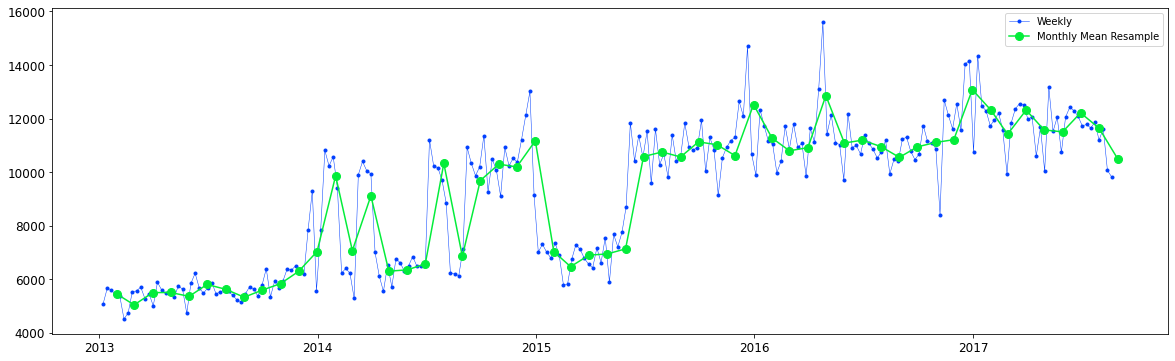

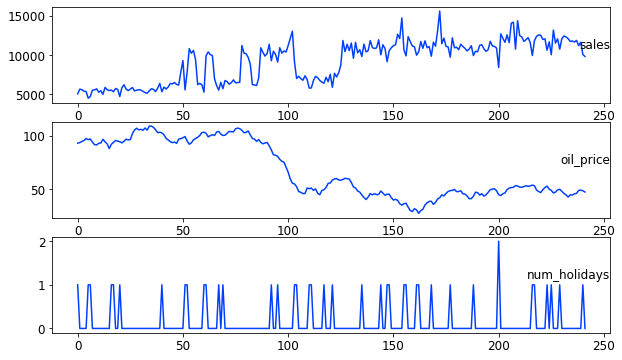

In [25]:
ts_visualisation(df,target_col)

## Decomposing and Exploring the Data

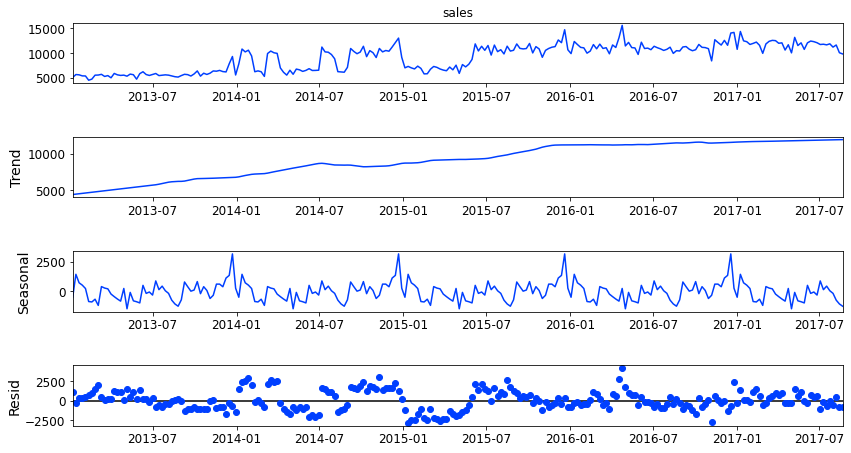

In [26]:
ts_decomposition(df, target_col, model = 'additive')

## ACF and PACF plots

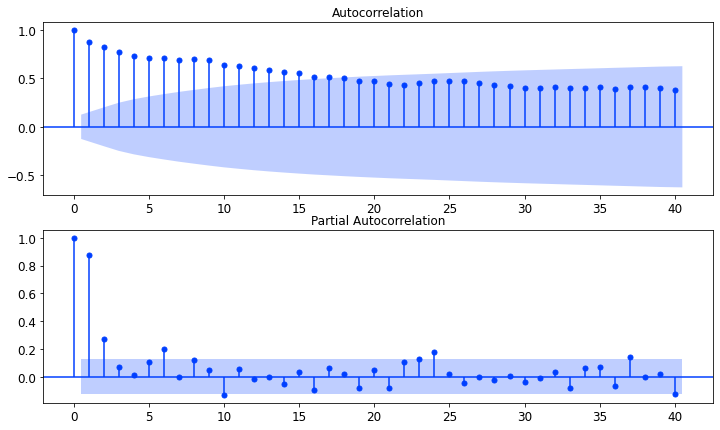

In [27]:
acf_pacf_plotting(df, target_col)

## Stationarity Test:  Dickey-Fuller

Time series data is said to be stationary if it does not exhibit trends or seasonality. That is, the mean, variance and covariance should be the same for any segment of the series, and are not functions of time.

ADF Statistic: -1.8632965830816817
p-value: 0.3495195582587611
n_lags: 7
Critial Values:
   1%, -3.4586084859607156
   5%, -2.873972159235721
   10%, -2.57339565928848
Do not reject the null hypothesis
Data has a unit root and is non-stationary
Differencing the serie 1 time(s), makes the data stationary


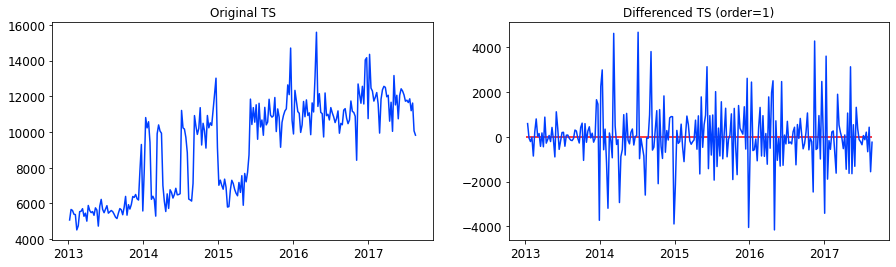

In [28]:
adf_test(df, target_col, alpha= 0.05)

## General Results

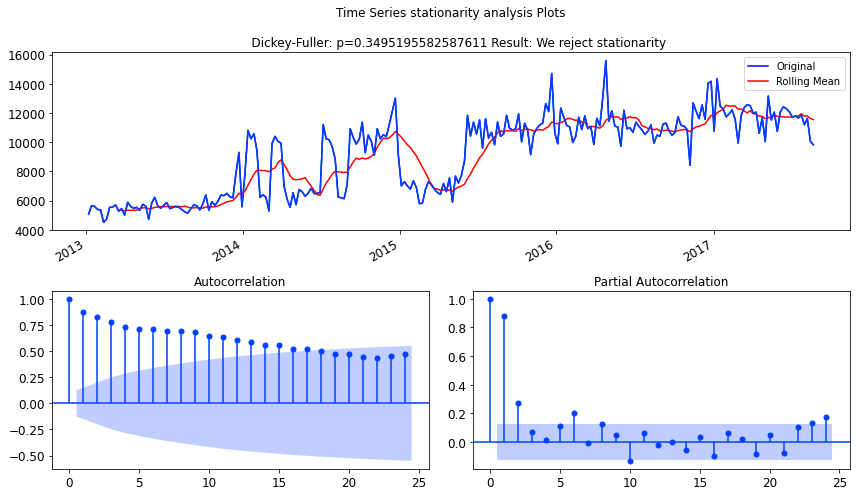

In [29]:
ts_sintetic_plot(df, target_col, lags=None, figsize=(12, 7), window = 12)

# Train-Test Split

In [30]:
train, test = split_train_test(df)

182 periods of training data 
 60 periods of testing data 


# From ARIMA to SARIMAX

In [31]:
m = 52 # usually: 52 for weekly data, 7 for daily data

## ARIMA

In [32]:
arima_order = tune_arima_model(train, target_col)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(0,0,0)[0] intercept   : BIC=3119.459, Time=0.02 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : BIC=3114.601, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : BIC=3112.648, Time=0.08 sec
 ARIMA(0,1,0)(0,0,0)[0]             : BIC=3114.366, Time=0.01 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : BIC=inf, Time=0.22 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : BIC=3114.694, Time=0.10 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : BIC=inf, Time=0.25 sec
 ARIMA(0,1,1)(0,0,0)[0]             : BIC=3107.762, Time=0.02 sec
 ARIMA(1,1,1)(0,0,0)[0]             : BIC=3103.328, Time=0.10 sec
 ARIMA(1,1,0)(0,0,0)[0]             : BIC=3109.597, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0]             : BIC=3107.715, Time=0.14 sec
 ARIMA(1,1,2)(0,0,0)[0]             : BIC=3107.895, Time=0.10 sec
 ARIMA(0,1,2)(0,0,0)[0]             : BIC=3110.129, Time=0.04 sec
 ARIMA(2,1,0)(0,0,0)[0]             : BIC=3113.412, Time=0.02 sec
 ARIMA(2,1,2)(0,0,0)[0]             : BIC=3

Result is be a SARIMA model

                               SARIMAX Results                                
Dep. Variable:                  sales   No. Observations:                  182
Model:               SARIMAX(1, 1, 1)   Log Likelihood               -1543.866
Date:                Sat, 15 Jan 2022   AIC                           3093.733
Time:                        20:06:18   BIC                           3103.328
Sample:                    01-07-2013   HQIC                          3097.623
                         - 06-27-2016                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5938      0.087      6.817      0.000       0.423       0.765
ma.L1         -0.8816      0.055    -16.109      0.000      -0.989      -0.774
sigma2      1.492e+06  

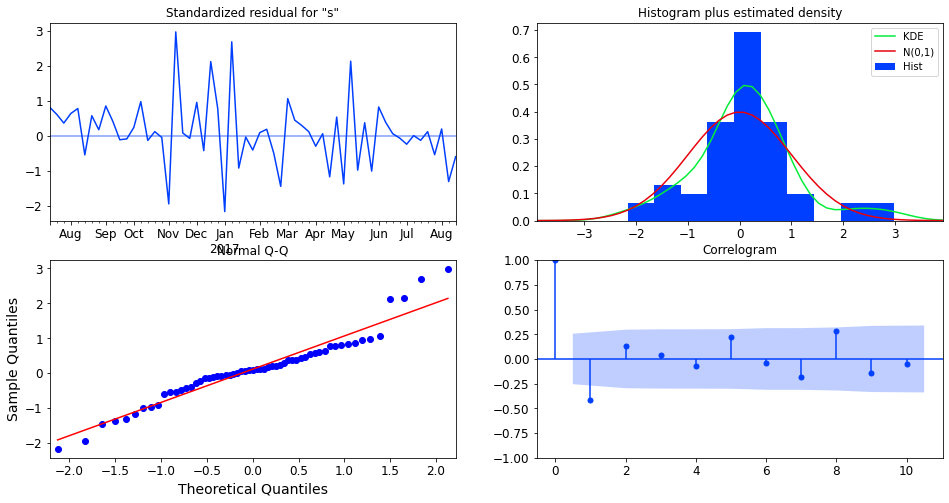

In [33]:
train_fit, test_results = fit_sarimax_model(train, test, target_col, 
                                            arima_order, exog='no')

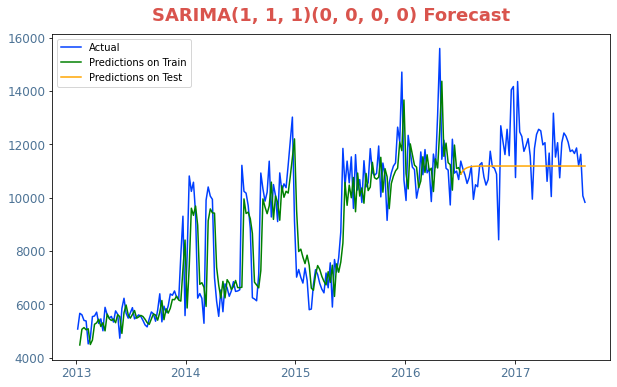

In [34]:
train_pred_sarima, test_pred_sarima = predict_with_sarima(df, target_col, train_fit, train, test)

In [35]:
evaluate(test, target_col, test_pred_sarima)

**Evaluation on test**

MSE Error: 1237989.909
RMSE Error: 1112.649949
Adjusted MAPE Error:  9.64676524%


## SARIMA

In [36]:
sarima_order, sarima_s_order=tune_sarima_model(train, target_col, seasonality = m)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : BIC=3099.704, Time=2.24 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : BIC=3119.459, Time=0.01 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : BIC=3097.787, Time=1.05 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : BIC=3100.340, Time=1.06 sec
 ARIMA(0,1,0)(0,0,0)[52]             : BIC=3114.366, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : BIC=3114.601, Time=0.02 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : BIC=inf, Time=5.80 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : BIC=3100.106, Time=3.62 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : BIC=3102.696, Time=0.44 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : BIC=3105.353, Time=18.26 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : BIC=3097.302, Time=0.98 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : BIC=inf, Time=4.91 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : BIC=3102.222, Time=1.86 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : BIC=3104.900, Time=14.44 sec
 ARIMA(0,1,1)(1,0,0)[52] in

Result is be a SARIMA model

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                  182
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1533.169
Date:                             Sat, 15 Jan 2022   AIC                           3074.339
Time:                                     20:09:28   BIC                           3087.133
Sample:                                 01-07-2013   HQIC                          3079.526
                                      - 06-27-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.7274      0.077      9.400      0.000       0.576       0.87

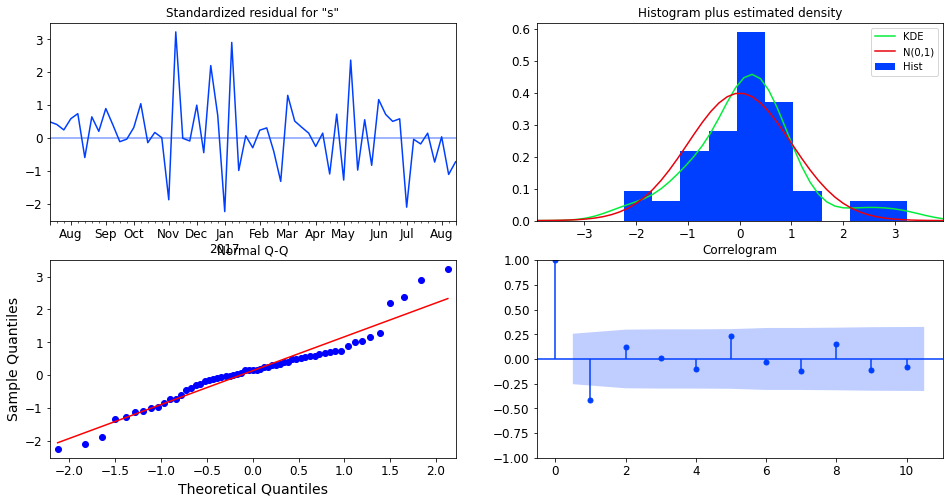

In [37]:
train_fit, test_results = fit_sarimax_model(train, test, target_col, 
                                            sarima_order, sarima_s_order,
                                            exog = 'no')

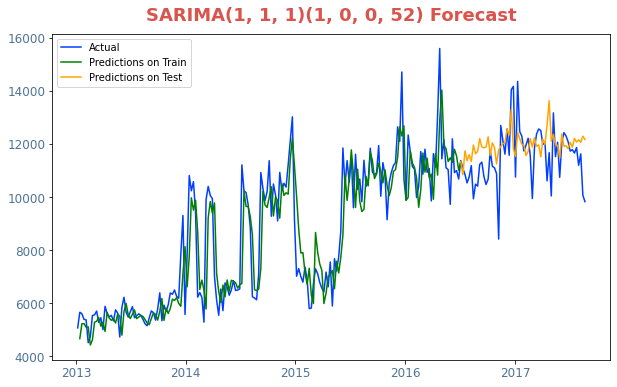

In [38]:
train_pred_sarima, test_pred_sarima = predict_with_sarima(df, target_col, train_fit, train, test)

In [39]:
evaluate(test, target_col, test_pred_sarima)

**Evaluation on test**

MSE Error: 1230112.115
RMSE Error: 1109.104195
Adjusted MAPE Error: 9.616023265%


## SARIMAX

In [40]:
sarimax_order, sarimax_s_order=tune_sarimax_model(train, target_col, seasonality = m)

Performing stepwise search to minimize bic
 ARIMA(0,1,0)(1,0,1)[52] intercept   : BIC=3099.704, Time=2.34 sec
 ARIMA(0,1,0)(0,0,0)[52] intercept   : BIC=3119.459, Time=0.02 sec
 ARIMA(1,1,0)(1,0,0)[52] intercept   : BIC=3097.787, Time=1.22 sec
 ARIMA(0,1,1)(0,0,1)[52] intercept   : BIC=3100.340, Time=1.17 sec
 ARIMA(0,1,0)(0,0,0)[52]             : BIC=3114.366, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[52] intercept   : BIC=3114.601, Time=0.03 sec
 ARIMA(1,1,0)(2,0,0)[52] intercept   : BIC=inf, Time=5.62 sec
 ARIMA(1,1,0)(1,0,1)[52] intercept   : BIC=3100.106, Time=3.04 sec
 ARIMA(1,1,0)(0,0,1)[52] intercept   : BIC=3102.696, Time=0.38 sec
 ARIMA(1,1,0)(2,0,1)[52] intercept   : BIC=3105.353, Time=15.75 sec
 ARIMA(0,1,0)(1,0,0)[52] intercept   : BIC=3097.302, Time=0.82 sec
 ARIMA(0,1,0)(2,0,0)[52] intercept   : BIC=inf, Time=4.32 sec
 ARIMA(0,1,0)(0,0,1)[52] intercept   : BIC=3102.222, Time=1.60 sec
 ARIMA(0,1,0)(2,0,1)[52] intercept   : BIC=3104.900, Time=12.93 sec
 ARIMA(0,1,1)(1,0,0)[52] in

                                      SARIMAX Results                                      
Dep. Variable:                               sales   No. Observations:                  182
Model:             SARIMAX(1, 1, 1)x(1, 0, [], 52)   Log Likelihood               -1516.551
Date:                             Sat, 15 Jan 2022   AIC                           3045.102
Time:                                     20:12:29   BIC                           3064.293
Sample:                                 01-07-2013   HQIC                          3052.882
                                      - 06-27-2016                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
x1           -17.7238     26.123     -0.678      0.497     -68.924      33.477
x2         -1296.6962    24

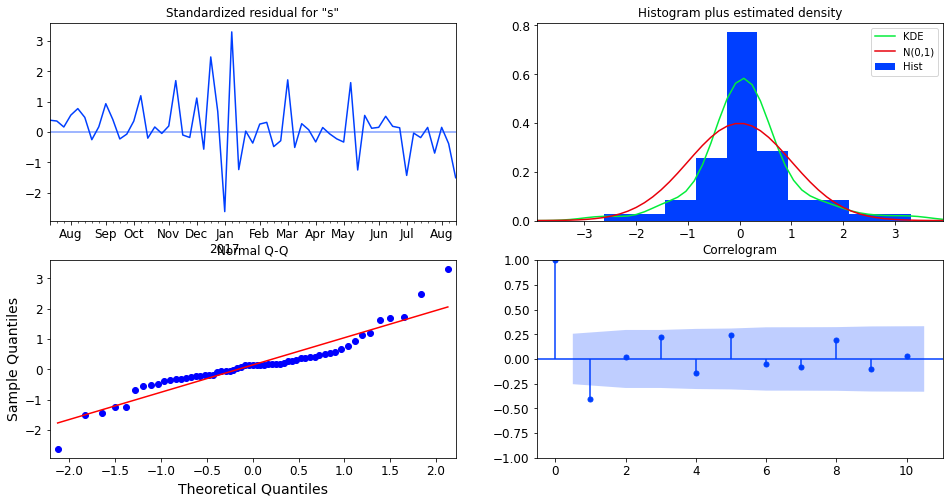

In [41]:
train_fit, test_results = fit_sarimax_model(train, test, target_col, 
                                            sarimax_order, sarimax_s_order,
                                            exog = 'yes')

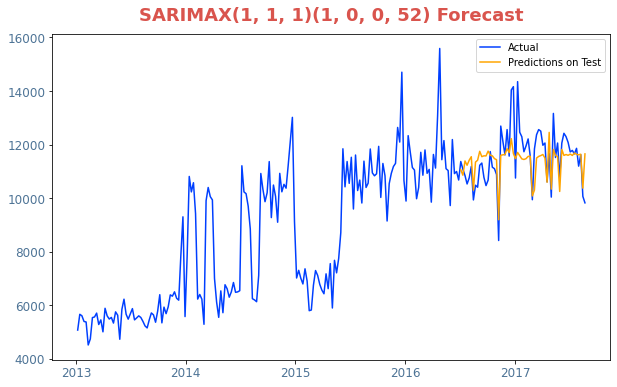

In [42]:
test_pred_sarimax = predict_with_sarimax(df, target_col, train_fit, train, test)

In [43]:
evaluate(test, target_col, test_pred_sarimax)

**Evaluation on test**

MSE Error: 713738.8207
RMSE Error: 844.8306461
Adjusted MAPE Error: 7.324750177%


# LSTM

Epoch 1/30
9/9 [==============================] - 2s 45ms/step - loss: 0.2717 - val_loss: 0.3153
Epoch 2/30
9/9 [==============================] - 0s 20ms/step - loss: 0.2312 - val_loss: 0.2039
Epoch 3/30
9/9 [==============================] - 0s 19ms/step - loss: 0.1842 - val_loss: 0.0575
Epoch 4/30
9/9 [==============================] - 0s 20ms/step - loss: 0.1421 - val_loss: 0.0255
Epoch 5/30
9/9 [==============================] - 0s 19ms/step - loss: 0.1375 - val_loss: 0.0306
Epoch 6/30
9/9 [==============================] - 0s 20ms/step - loss: 0.1343 - val_loss: 0.0238
Epoch 7/30
9/9 [==============================] - 0s 19ms/step - loss: 0.1311 - val_loss: 0.0225
Epoch 8/30
9/9 [==============================] - 0s 19ms/step - loss: 0.1290 - val_loss: 0.0299
Epoch 9/30
9/9 [==============================] - 0s 20ms/step - loss: 0.1300 - val_loss: 0.0267
Epoch 10/30
9/9 [==============================] - 0s 20ms/step - loss: 0.1249 - val_loss: 0.0225
Epoch 11/30
9/9 [============

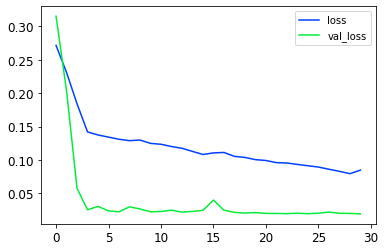

In [44]:
trained_lstm = fit_lstm_model(train, test, target_col, n_inputs = m, batch_size = 16, 
                   patience = 20, units = 30, act_f = 'relu')

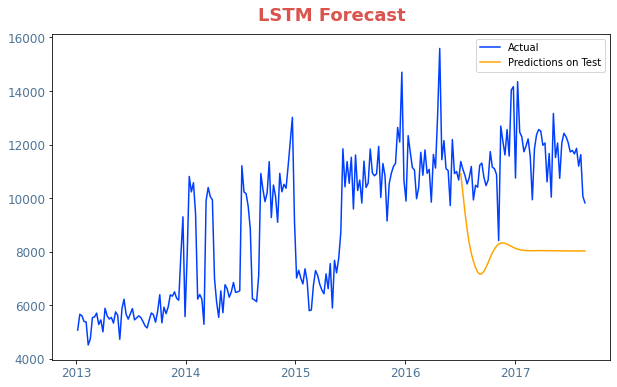

In [45]:
sales_pred = predict_with_lstm(df, train, test,'sales',trained_lstm, n_inputs=m)

In [49]:
evaluate(test, target_col, sales_pred)

**Evaluation on test**

MSE Error: 13168834.18
RMSE Error: 3628.888835
Adjusted MAPE Error: 31.46276033%
